# Disk detection used to test crystal system prediction with augmeted data 
# Sam Gleason - 022724

In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
# from scipy.ndimage import gaussian_filter
# from scipy.ndimage import binary_erosion, binary_dilation
# from scipy.interpolate import RegularGridInterpolator
# from skimage.measure import regionprops, label
print(py4DSTEM.__version__)

0.14.14


In [3]:
# import cupy

In [4]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
# import matplotlib.font_manager as fm

In [2]:
# file_path = 'D:/NCEM_4DSTEM/TEAM_I/FNAt hom unirrad/230330 pt 2/'
# file_probe = 'D:/NCEM_4DSTEM/TEAM_I/FNAt hom irrad/230329/vacuum/vacuum_probe.dm4'
# file_probe = file_path + 'vacuum_probe.dm4'
# file_probe = file_path + 'vacuum_probe_02_more.dm4'

file_path = 'C:/Users/smgls/Downloads/Disk detection reference/240130/gold sam/'
file_data = file_path + '240130-gold-nanobeam-00_master.h5'
# file_probe = file_path + 'vacuum_probe_03.dm4'
file_analysis = file_path + 'analysis_dataset00_'



In [3]:
bin_factor = 1

# Load data

In [4]:
dataset = py4DSTEM.import_file(
    file_data,
    binfactor = bin_factor,
    scan_width = 256,
)

Dataset is uint32 but will be converted to uint16


In [5]:
dataset

DataCube( A 4-dimensional array of shape (256, 256, 192, 192) called 'datacube',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
)

In [6]:
# dataset_probe = py4DSTEM.import_file(
#     file_probe,
#     binfactor = bin_factor,
#     dtype ='uint16',
# )

In [7]:
dataset.get_dp_mean();

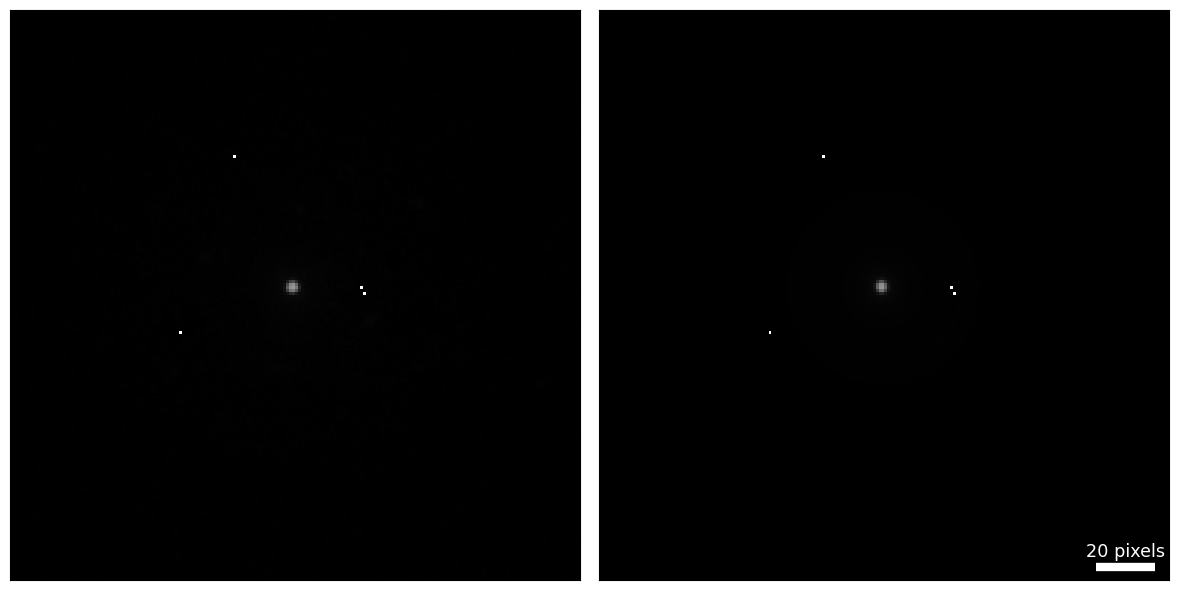

In [8]:
py4DSTEM.show(
    [
        dataset.data[40,125],
        dataset.tree('dp_mean'),
    ],
    power = 0.5,
    vmax = 1,
    ticks = False,
)

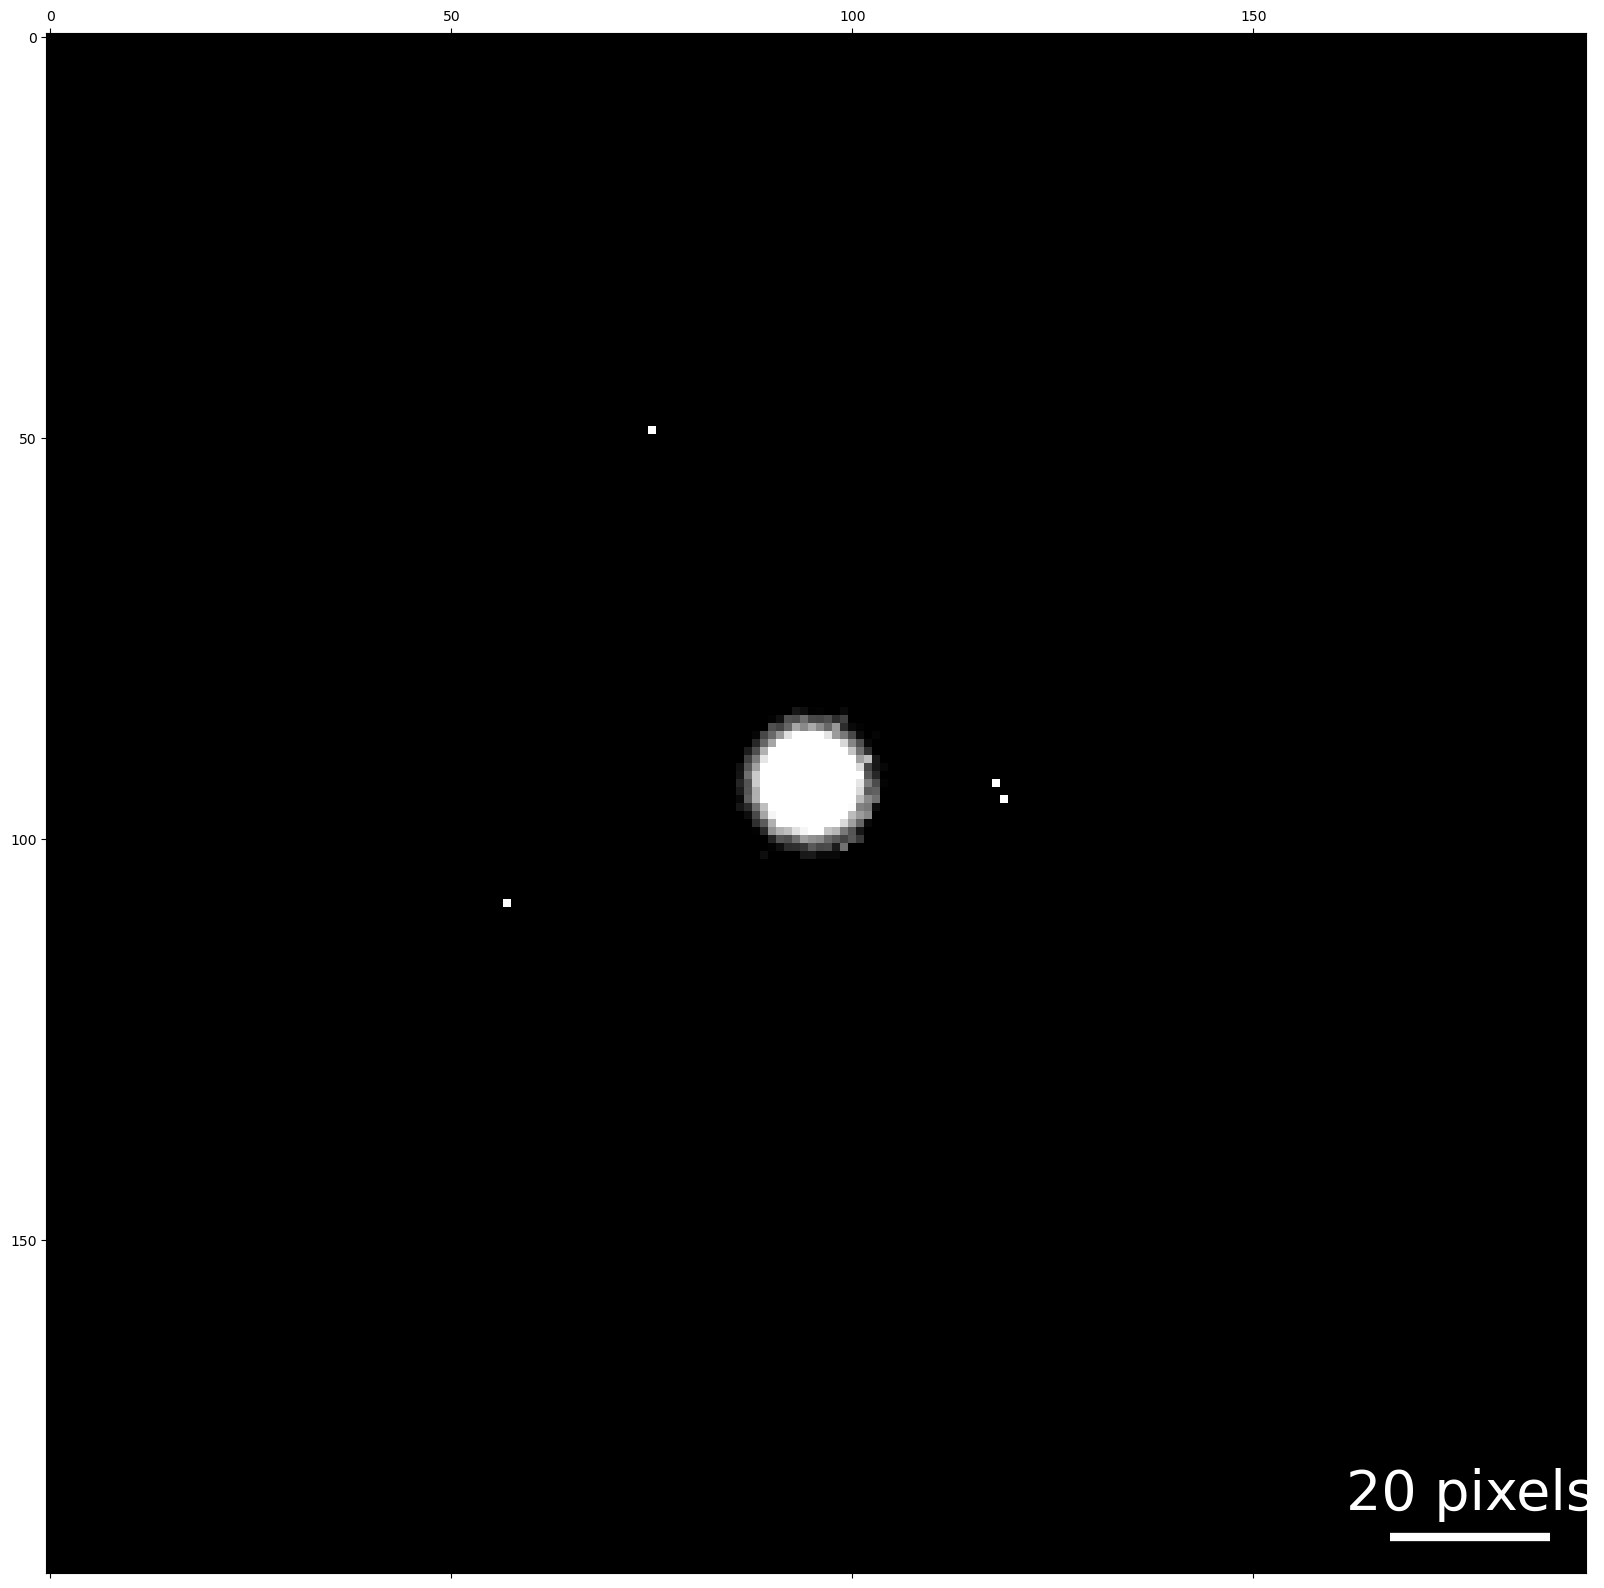

In [9]:
# Looking for hot pixels
py4DSTEM.show(
#         dataset.data[40,125],
    dataset.tree('dp_mean'),
#     power = 0.5,
#     vmax = 1,
#     cmap = 'turbo',
    intensity_range = 'absolute',
    vmin = 10,
    vmax = 20,
    figsize = (20,20),
)

There are enough hot pixels that it might be worth filtering them out.  This should be performed at bin 1, so we will restructure a bit.

In [10]:
dataset, mask = py4DSTEM.preprocess.filter_hot_pixels(
    dataset,
    thresh = 10 * bin_factor**2,
    return_mask = True,
    ind_compare=2,

)

Cleaning pixels: 100%|███████████████████████████████████████████████████| 65536/65536 [00:05<00:00, 13033.94 images/s]


In [11]:
# Print number of hot pixels
print(np.sum(mask))

6


In [12]:
# dataset_probe = py4DSTEM.preprocess.filter_hot_pixels(
#     dataset_probe,
#     thresh = 10 * bin_factor**2,
# )

In [13]:
# dataset.get_dp_max();
# dataset.get_dp_mean();

In [14]:
dataset.get_dp_mean();
dataset.get_dp_max();


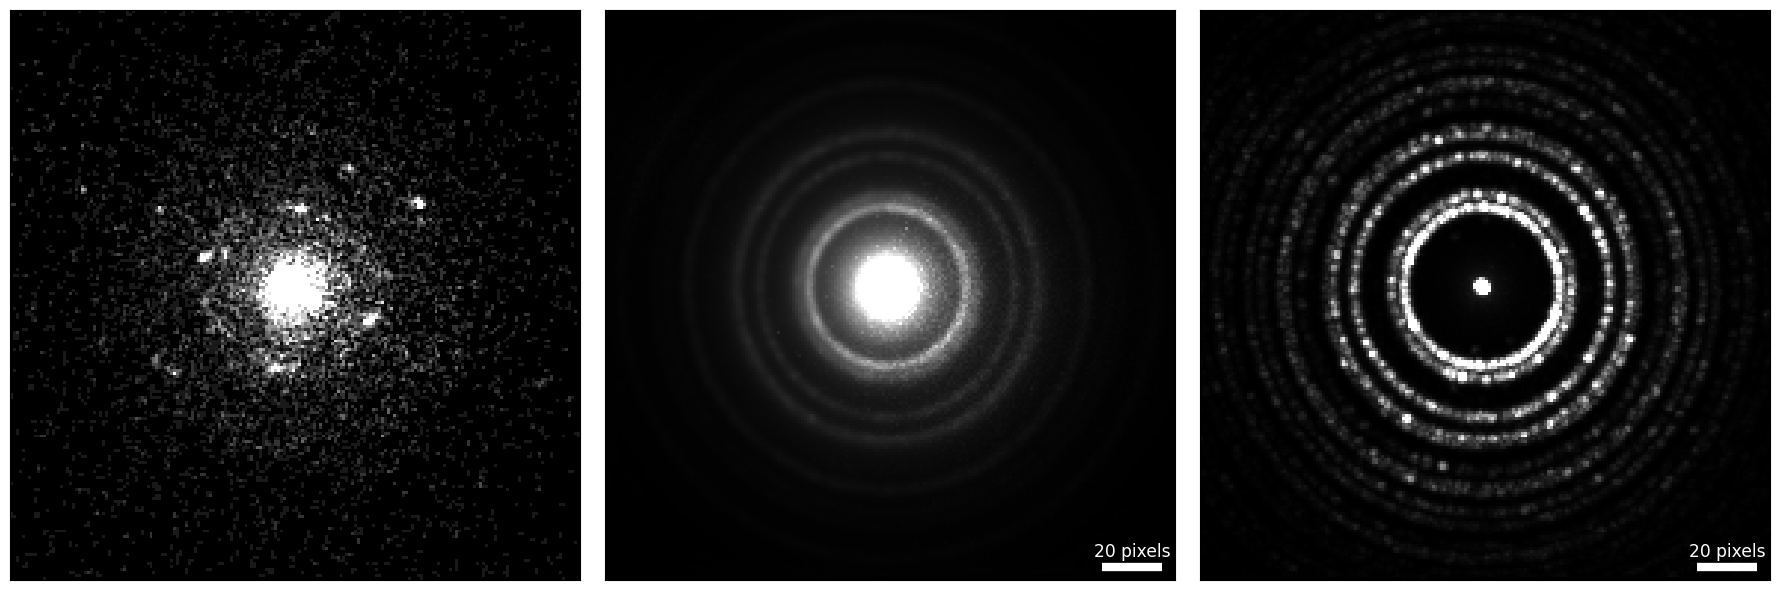

In [15]:
py4DSTEM.show(
    [
        dataset.data[40,125],
        dataset.tree('dp_mean'),
        dataset.tree('dp_max'),
    ],
    # power = 0.5,
    vmax = 0.99,
    ticks = False,
)

# Virtual imaging

In [16]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, probe_qx0, probe_qy0 = dataset.get_probe_size(
    thresh_lower=0.5,
    thresh_upper=0.6,
)

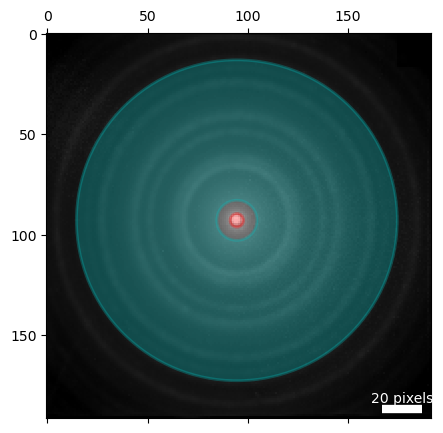

In [17]:
# virtual BF and DF

expand_BF = 2
radii_DF = (10 / bin_factor, 80/bin_factor)

center = (probe_qx0, probe_qy0)
radius_BF = probe_semiangle + expand_BF

# Plot the detectors
py4DSTEM.visualize.show(
    dataset.tree('dp_mean'), 
    annulus = {
        'center':center,
        'radii':radii_DF,
        'alpha':0.3,
        'fill':True,
        'color':'c',
    },
    circle = {
        'center':center,
        'R':radius_BF,
        'alpha':0.3,
        'fill':True,
        'color':'r',
    },
    vmax=1, 
    scaling='log',
)

In [18]:
# Generate virtual images
dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius_BF),
    name = 'bright_field',
)
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii_DF),
    name = 'dark_field',
);

100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:03<00:00, 17463.16it/s]


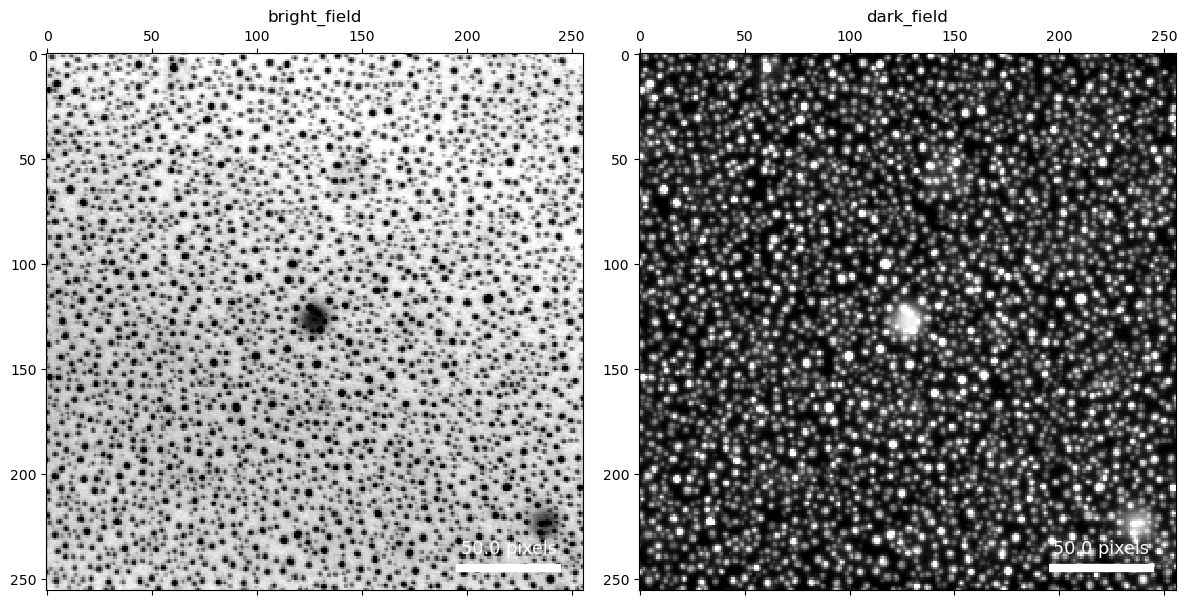

In [19]:
fig,ax = py4DSTEM.show(
    [
        dataset.tree('bright_field'),
        dataset.tree('dark_field'),
    ],
    figsize=(12,7),
    # bordercolor = 'w',
    cmap='gray',
    returnfig = True,
    title = [
        'bright_field',
        'dark_field',
    ],
    ticks = True,
)

In [20]:
fig.savefig(file_analysis + 'virtual_BF_DF.pdf')

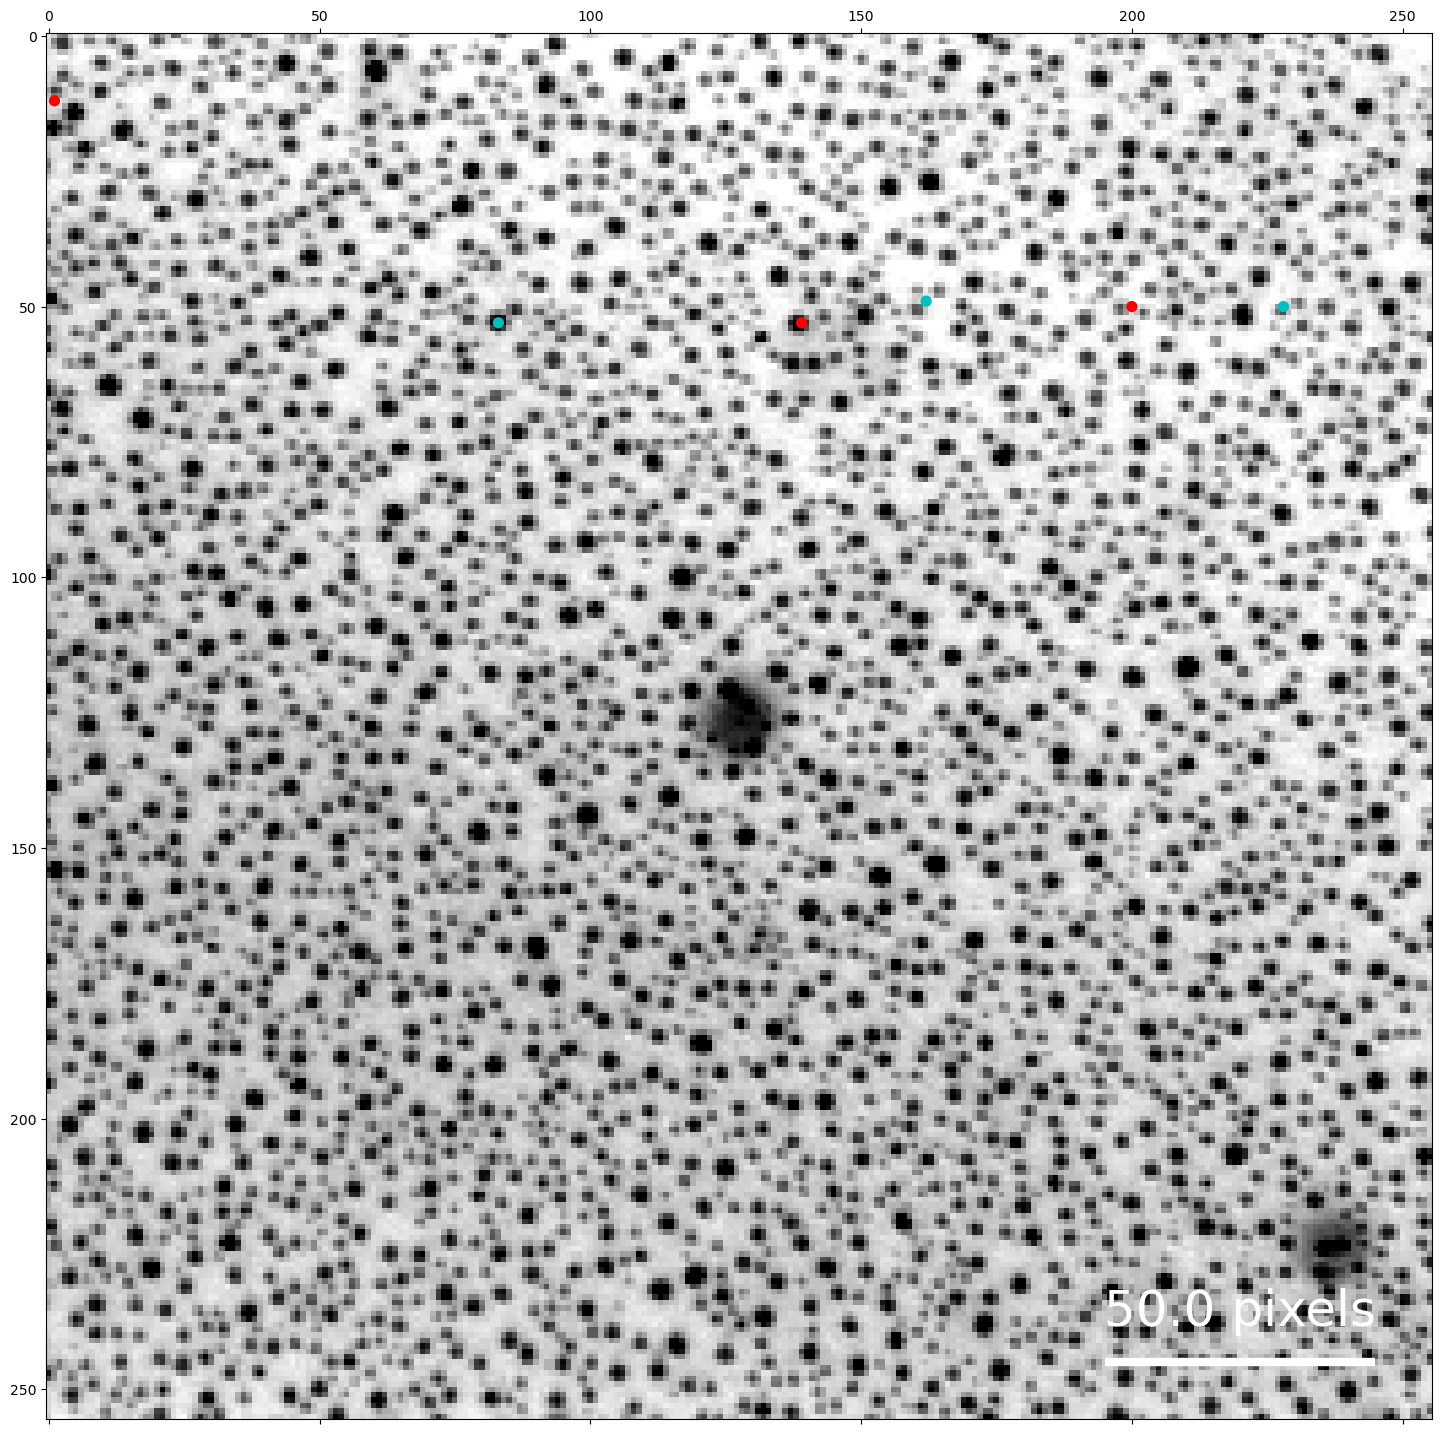

In [59]:

# Choose some diffraction patterns to use for hyperparameter tuning

rxs = 12,53,53,49,50,50
rys = 1,83,139,162,200,228

colors=['red','c','red','c','red','c']

py4DSTEM.visualize.show_points(
    dataset.tree('bright_field'),
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(18,18)
)

### Code for estimating vacuum probe from dataset

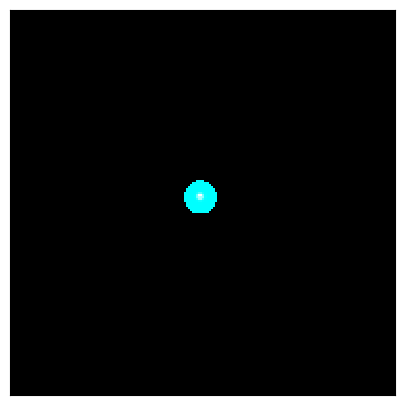

In [22]:
# Generate a vacuum probe from the average diffraction patterns.
# make a mask around the zero beam

mask_probe = py4DSTEM.process.utils.make_circular_mask(
    dataset.Qshape,
    center,
    8/bin_factor,
)

py4DSTEM.show(
    [
        dataset.tree('dp_mean'),
        mask_probe,
    ],
    vmax = 1,
    ticks = False,
    combine_images = True,
)

In [23]:
# alignment is probably not necessary, but leave in for now

ROI = np.zeros(dataset.Rshape,dtype='bool')
ROI.ravel()[::100] = True

probe = dataset.get_vacuum_probe(
    ROI = ROI,
    align = True,
    mask = mask_probe,
    threshold=0.0,
)

100%|███████████████████████████████████████████████████████████████████████████████| 655/655 [00:02<00:00, 253.72it/s]


# Disk detection

In [24]:
# probe = dataset_probe.get_vacuum_probe(
#     align=True,
#     threshold=0.0,
# )

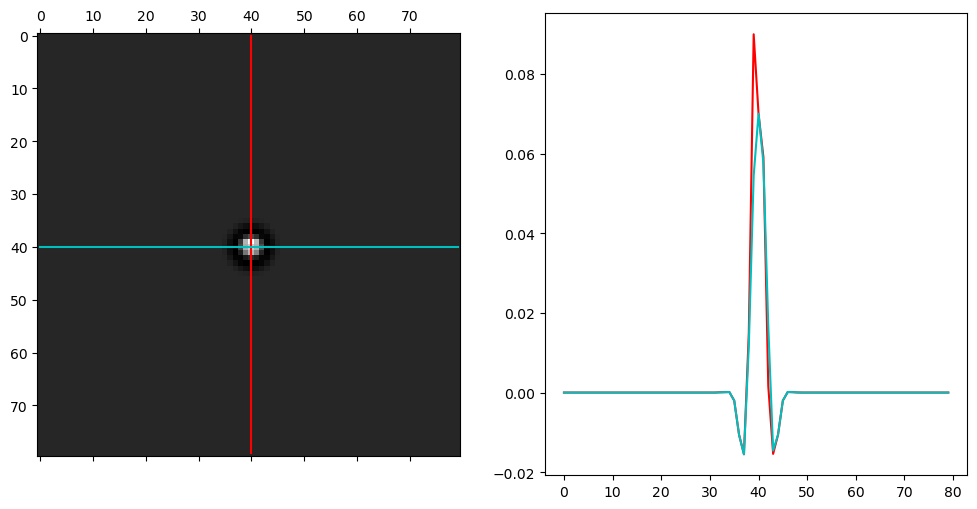

In [25]:
probe_kernel = probe.get_kernel(
    mode = 'sigmoid',
    radii = (probe_semiangle * 2, probe_semiangle * 4.0)
)

py4DSTEM.visualize.show_kernel(
    probe_kernel,
    R = 40,
    L = 40,
    W = 1
)

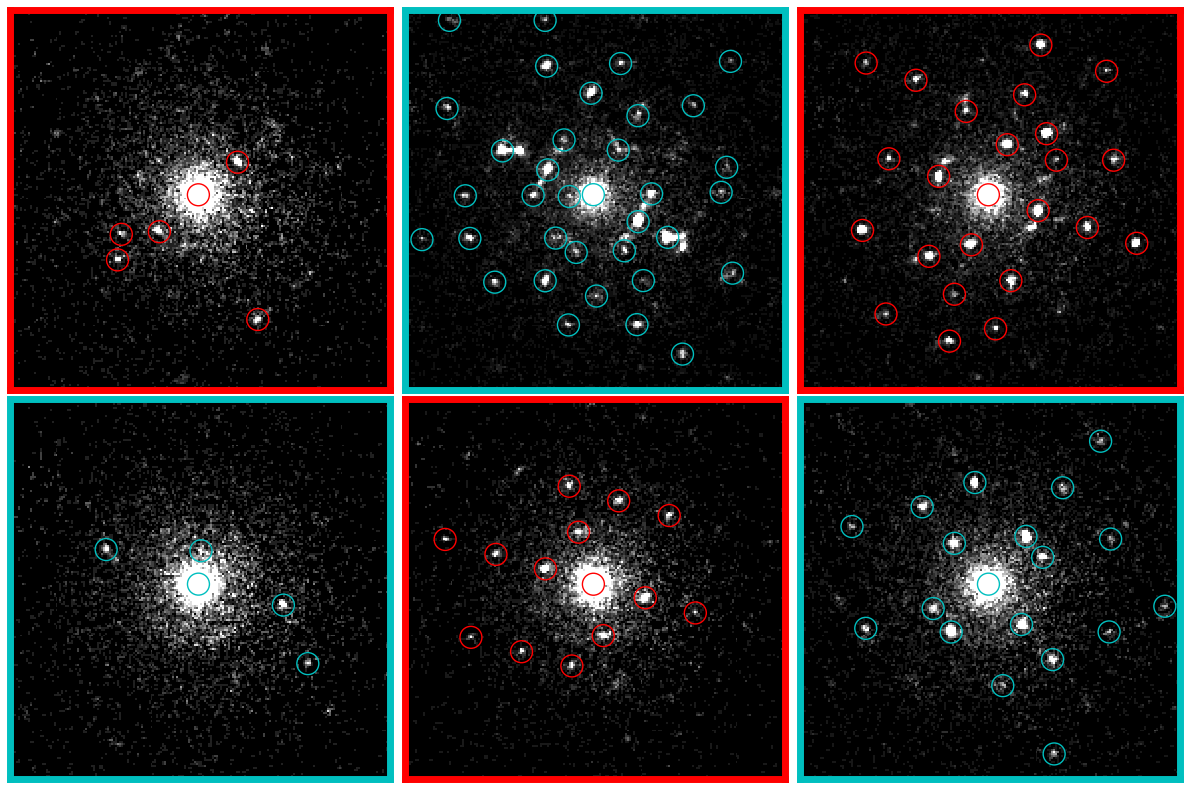

In [65]:
# Test hyperparameters 

# Hyperparameters
detect_params = {
    'corrPower': 1,
    'sigma': 0,
    'edgeBoundary': 4,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 2, # tweak
    'minPeakSpacing': 12, # tweak
    # 'subpixel' : 'multicorr',
    'subpixel' : 'poly',
    'upsample_factor': 8,
    'maxNumPeaks': 1000,
   'CUDA': True,
}

disks_selected = dataset.find_Bragg_disks(
    data = (rxs, rys),
    template = probe_kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(4,4),
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 250,
    vmax=0.99,
    # power = 0.5,
)

In [66]:
# Find Bragg peaks in all probe positions.
bragg_peaks = dataset.find_Bragg_disks(
    template = probe_kernel,
    **detect_params,
)

Using 26 batches of 2529 patterns each...


Finding Bragg disks in batches: 100%|███████████████████████████████████████████████| 26/26 [05:04<00:00, 11.71s/batch]


Analyzed 65536 diffraction patterns in 0.0h 5.0m 4.59s
(avg. speed 215.1601 patterns per second)


In [67]:
# Save Bragg disk locations
file_braggdisks_raw = file_analysis + 'TEST_braggdisks_raw.h5'

In [68]:
bragg_peaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       1
             R_pixel_size:       1
             Q_pixel_units:      pixels
             R_pixel_units:      pixels
             QR_flip:            False
             probe_semiangle:    1.4139699280530806
             qx0_mean:           92.88915432114348
             qy0_mean:           94.50524534612896
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
             qx0:                2D-array
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_shift:          2D-array
)

In [69]:
# bragg_peaks.calibration.set_R_pixel_units('um')

In [70]:
# Save Bragg disk positions
py4DSTEM.save(
    file_braggdisks_raw,
    bragg_peaks,
    mode='o',
)

100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:07<00:00, 8542.91it/s]


# Load the peak data

In [71]:
# This step is optional, but can serve as a checkpoint in the analysis
file_braggdisks_raw = file_analysis + 'TEST_braggdisks_raw.h5'
py4DSTEM.print_h5_tree(file_braggdisks_raw)

/
|---datacube_root
    |---braggvectors
        |---_v_uncal




In [72]:
# # uncomment here to reload
# bragg_peaks = py4DSTEM.read(
#     file_braggdisks_raw, 
#     root = 'dm_dataset_root/braggvectors'
# )
# bragg_peaks

# Center coordinate system

In [73]:
# Guess the center coordinate, specify the radial range for fitting peak pairs.
# We're using this method because currently the "brightest peak" method 

# center_guess = (402/bin_factor,422/bin_factor)
# radial_range = (20/bin_factor,400/bin_factor)

# # Show the ADF detector, overlaid over a new BVM
# bragg_vector_map = bragg_peaks.get_bvm(mode='raw')
# py4DSTEM.show(
#     bragg_vector_map, 
#     annulus = {
#       'center':center_guess,
#       'radii' : radial_range,
#       'alpha':0.3,
#       'fill':True
#     },
#     vmax = 1,
# )

In [74]:
# Compute the origin positions pattern-by-pattern
origin_meas = bragg_peaks.measure_origin(
    score_method = 'intensity',
    # center_guess = center_guess,
    # radii = radial_range,
)

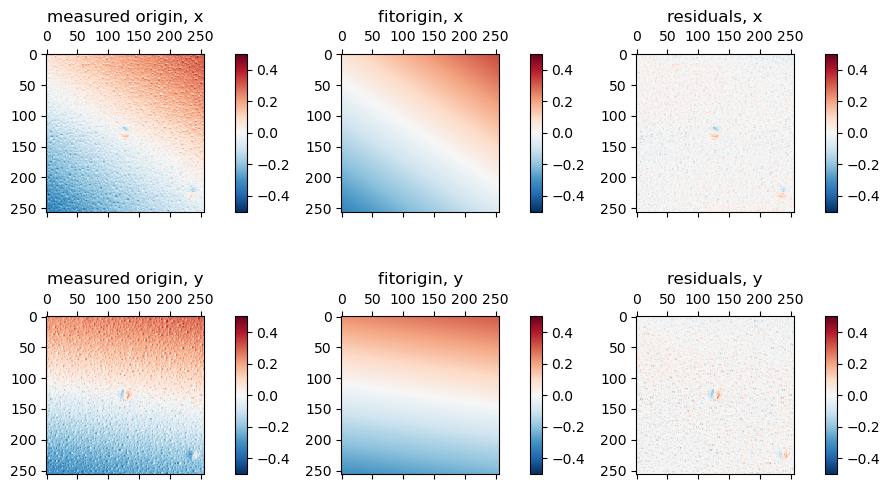

In [75]:
# Fit a plane to the measured origins
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin(
    plot_range = 0.5,
)

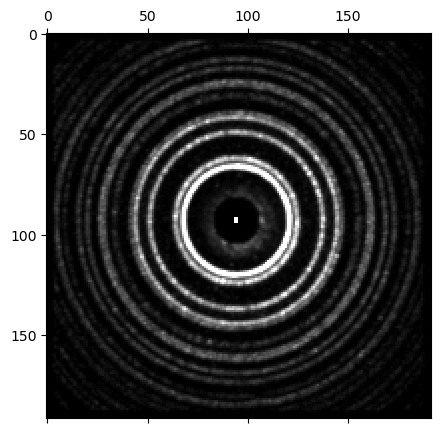

In [76]:
# Plot the BVM
bvm_vis_params = {
    'vmax': 0.99,
    'power':0.5,
}

# Compute the Bragg vector map
bvm = bragg_peaks.get_bvm(mode = 'cal')

# plot the Bragg vector map
py4DSTEM.show(
    bvm,
    **bvm_vis_params,
)

# Remove false positives and origin

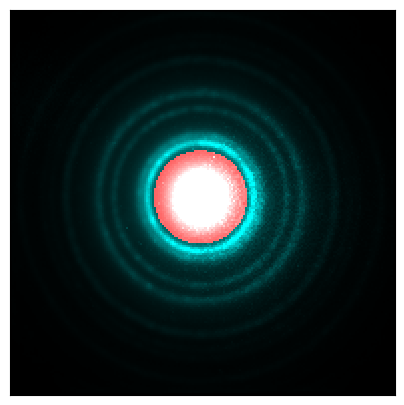

In [77]:
# define mask
mask_false_pos = py4DSTEM.process.utils.make_circular_mask(
    dataset.Qshape,
    center,
    23/bin_factor,
)

py4DSTEM.show(
    [
        mask_false_pos,
        dataset.tree('dp_mean'),
    ],
    vmax = 0.98,
    ticks = False,
    combine_images = True,
)

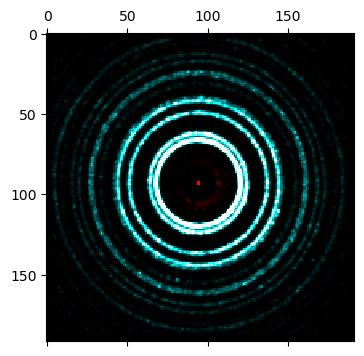

In [78]:
bragg_peaks_masked = bragg_peaks.mask_in_Q(
    mask_false_pos,
)

# Create a bragg vector map (2D histogram of all detected bragg peaks) for both raw and masked Bragg peaks
bragg_vector_map = bragg_peaks.get_bvm(mode='raw')
bragg_vector_map_masked = bragg_peaks_masked.get_bvm(mode='raw')

# Plot a comparison image between the original and masked bragg vector map
py4DSTEM.show(
    [
        bragg_vector_map, 
        bragg_vector_map_masked,
    ],
    combine_images = True,
    figsize = (4,4),
    vmax=0.98,
) 

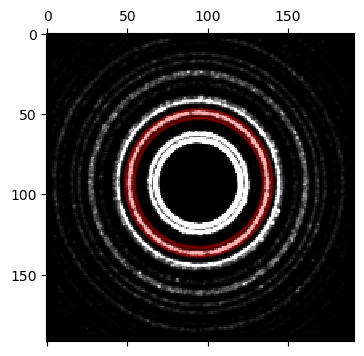

In [79]:
# We will measure the ellipticity by fitting one of the Bragg peak rings.
# First choose the radial range in q:
#q_range = (19, 21)
q_range = (40,46)

py4DSTEM.show(
    bragg_vector_map_masked,
    intensity_range='absolute',
    vmin=0,
    vmax=1e3,
    annulus={
        'center':bragg_peaks_masked.calibration.get_origin_mean(),
        'radii': q_range,
        'fill':True,
        'color':'r',
        'alpha':0.3
    },
    figsize = (4,4),
    #ticks = False,
)

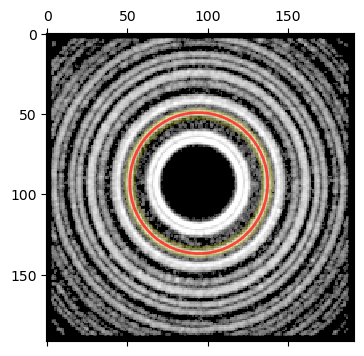

In [80]:
bragg_peaks_masked.fit_p_ellipse(
    bragg_vector_map_masked,
    center = bragg_peaks_masked.calibration.get_origin_mean(),
    fitradii = q_range,
    figsize = (4,4),
)

In [81]:
theta = 0
flip = False

In [82]:
pixel_size_inv_Ang = 0.016

In [83]:
bragg_peaks_masked.calibration.set_Q_pixel_size(pixel_size_inv_Ang)
bragg_peaks_masked.calibration.set_Q_pixel_units('A^-1')


In [84]:
a_lat = 4.08
atom_num = 79
k_max = 1.5


pos = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])

# Make crystal
crystal = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    a_lat)
# Calculate structure factors
crystal.calculate_structure_factors(k_max)

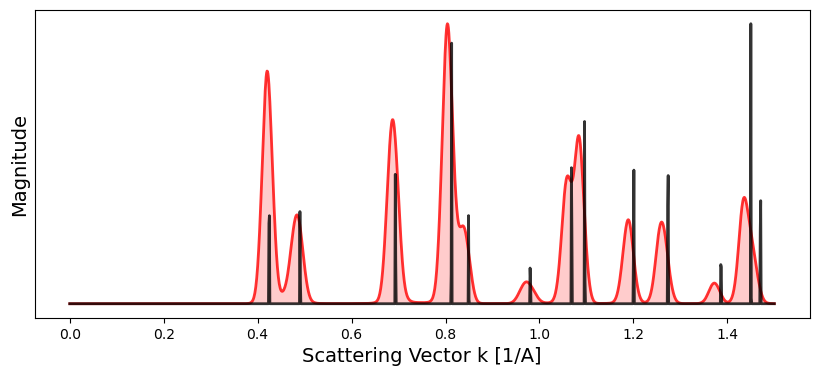

In [85]:
crystal.plot_scattering_intensity(
    bragg_peaks = bragg_peaks_masked,
    bragg_k_power = 2.0,
)

   Initial pixel size = 0.016 A^-1
Calibrated pixel size = 0.01616651 A^-1


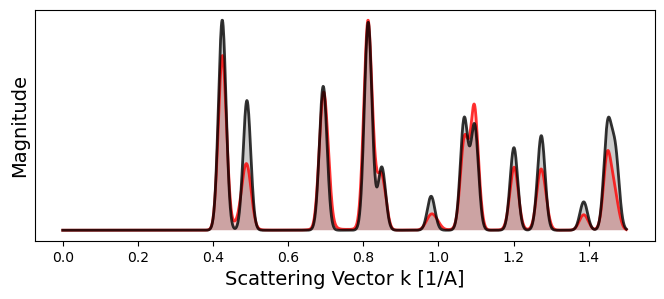

In [86]:
print('   Initial pixel size = ' + \
    str(np.round(bragg_peaks_masked.calibration.get_Q_pixel_size(),8)) + \
    ' ' + bragg_peaks_masked.calibration.get_Q_pixel_units())

# Calibrate pixel size
bragg_peaks_cali = crystal.calibrate_pixel_size(
    bragg_peaks = bragg_peaks_masked,
    bragg_k_power = 2.0,
    plot_result = True,
    figsize = (8,3),
    fit_all_intensities=False,
)

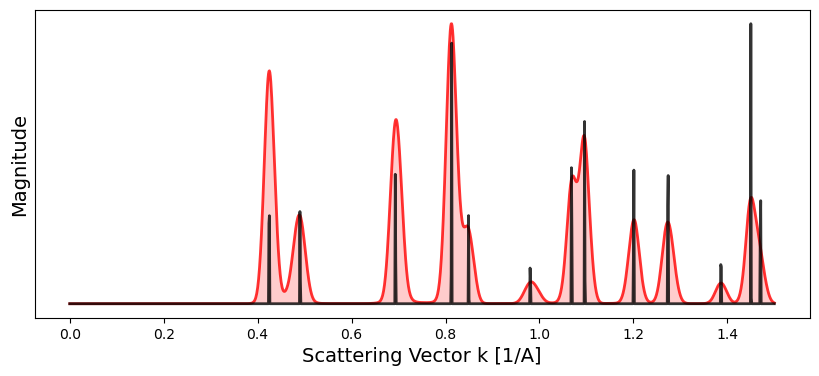

In [87]:
crystal.plot_scattering_intensity(
    bragg_peaks = bragg_peaks_cali,
    bragg_k_power = 2.0,
)

In [88]:
# Save Bragg disk locations
file_braggdisks_cali = file_analysis + 'TEST_braggdisks_cali.h5'

In [89]:
# Save Bragg disk positions
py4DSTEM.save(
    file_braggdisks_cali,
    bragg_peaks_cali,
    mode='o',
)

100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:07<00:00, 8437.53it/s]


In [90]:
print(bragg_peaks.cal[70,70].data)
print(bragg_peaks_cali.cal[70,70].data)


[(-3.37056958e-02,  9.93726033e-03, 7.31433012e+03)
 (-1.62220998e+01,  4.01460237e+01, 6.49817669e+00)
 ( 1.48101953e+01, -4.09556863e+01, 5.78048614e+00)
 ( 4.89989045e+01, -1.09030147e+01, 4.31305862e+00)
 (-5.07004370e+01,  1.16475089e+01, 3.67832812e+00)
 ( 2.62384217e+01, -1.27250178e+01, 2.49521429e+00)
 (-1.96997226e+01, -2.10527835e+01, 2.39583482e+00)
 ( 5.26664676e+01,  4.23899125e+01, 2.33202240e+00)
 (-5.50862803e+01, -4.27662800e+01, 2.12397356e+00)]
[(-0.25804175,  0.64947171, 6.49817669)
 ( 0.23574553, -0.66250449, 5.78048614)
 ( 0.7752449 , -0.1780715 , 4.31305862)
 (-0.80217983,  0.19016867, 3.67832812)
 ( 0.41539615, -0.20665931, 2.49521429)
 (-0.31072129, -0.33952025, 2.39583482)
 ( 0.83122682,  0.6831348 , 2.3320224 )
 (-0.86947774, -0.68912636, 2.12397356)]
